<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Защита персональных данных клиентов

Вам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## Загрузка данных

In [1]:
# загрузим необходимые бибилиотеки
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# загрузим данные
df = pd.read_csv('/datasets/insurance.csv')
df.info()
display(df.sample(10))
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
3332,0,21.0,36800.0,1,0
4310,0,49.0,38100.0,2,1
4208,1,42.0,43100.0,0,1
3935,1,36.0,53000.0,1,0
241,1,27.0,32400.0,1,0
953,1,18.0,38800.0,1,0
3341,1,29.0,36000.0,1,0
4254,0,33.0,25200.0,2,0
2841,1,26.0,47400.0,0,0
2323,0,22.0,45800.0,1,0


153

Данные клиентов страховой компании, содержат информацию о поле, возрасте, зарплате застрахованного лица, количестве членов семьи и количестве страховых выплат за последние `5` лет.  
`5` столбцов, `5000` строк.  
Все данные без пропусков, типа `int64` или `float64` .   
Целевой признак - `Страховые выплаты` .  
Обнаружены `153` дубликата объектов - оставим дубли, данные могли быть от разных клиентов.  

In [3]:
# описательные статистики
df.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Пол закодирован:  `0` или `1` .  
Возраст от `18` до `65` .  
Зарплата от `5300` до `79000` .  
Членов семьи может быть от `0` до `6` .  
Страховые выплаты бинарны, максимум страховых выплат одному клиенту: `5` .  

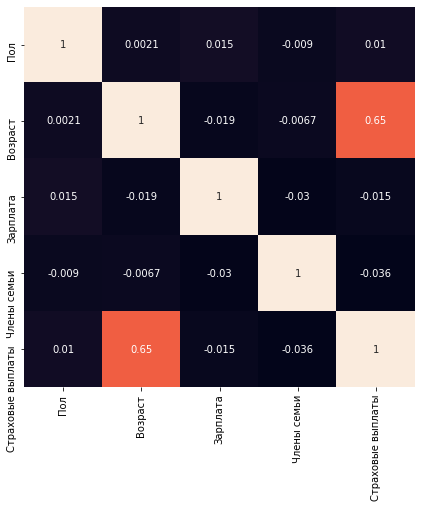

In [4]:
# кореляционная матрица
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(df.corr(), annot=True, ax=ax, cbar=False)
plt.show()

Заметна корреляция между возрастом и страховыми выплатами. 

In [5]:
# функция для проверки на целочисленность
def integer(n):
    return sum(n%1)
integer(df['Возраст'])

0.0

В столбце `Возраст` данные можно привести в целочисленный формат.

In [6]:
# столбец возраст приведём к типу int
df['Возраст'] = df['Возраст'].astype('int')
df['Возраст'].dtypes

dtype('int64')

In [7]:
# проверим столбец с зарплатой на целочисленность
integer(df['Зарплата'])

3.0000000001200533

В столбце с зарплатой есть дробные значения. Оставим как есть.

Данные адекватны и предобработаны, готовы к обучению модели.

## Умножение матриц

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

- $E$ - единичная матрица 

- $a'$ - предсказания с умноженными признаками на обратимую матрицу

- $w'$ - вектор весов линейной регрессии с умноженными признаками на обратимую матрицу

- $MSE$ - средняя квадратическая ошибка (mean squared error)

- $MSE'$ - средняя квадратическая ошибка с умноженными признаками на обратимую матрицу

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** 

$$w' = P^{-1}w $$
$$  a' = a$$
$$MSE' = MSE$$

 При умножении признаков на обратимую матрицу, качество линейной регрессии не изменится.

**Обоснование:** 


$$w' = ((XP)^{T}XP)^{-1}(XP)^{T}y = P^{-1}(X^{T}X)^{-1}(P^{T})^{-1}P^{T}X^{T}y = P^{-1}(X^{T}X)^{-1}EX^{T}y = P^{-1}w$$
$$a' = (XP)(P)^{-1}w = XEw = Xw = a$$
$$MSE = n^{-1}\displaystyle\sum_{i=1}^{n} (y - a)^{2} = n^{-1}\displaystyle\sum_{i=1}^{n} (y - a')^{2} = MSE'$$

## Алгоритм преобразования

**Алгоритм**

* выделяем целевой признак;
* кодируем нецелевые признаки, посредством умножения на квадратную матрицу из случайных чисел по размеру совпадающую с количеством признаков;
* проверям корректность работы шифровальшика, декодировав зашифрованные данные и сравнив их с исходными.

**Обоснование**  

Предсказания модели, с признаками, умноженными на квадратную обратимую матрицу, размерностью равной количеству признаков, равны исходным предсказаниям, как доказано в предыдущем пункте.

Другими словами, в процессе шифрования формируются новые признаки, которые являются линейной комбинацией старых признаков с определенными весами ($p$), при этом линейное преобразование каждого признака может быть представлено в виде изменения коэффициента при нем: $w' = P^{-1}w$, то есть коэффициенты можно разделить на два компонента ($P^{-1}$ и $w$), при этом $P^{-1}$ будет восстанавливать признаки до исходного состояния ($XPP^{-1} = X$), ну и, наконец, восстановленные признаки умножаются на вторую компоненту - свои изначальные коэфиициенты.


In [8]:
# выделим целевой признак
features = df.drop(['Страховые выплаты'], axis=1)
target = df['Страховые выплаты']
display(features.sample())
target.sample()

,Пол,Возраст,Зарплата,Члены семьи
405,1,28,17500.0,2


933    0
Name: Страховые выплаты, dtype: int64

In [9]:
# создадим квадратную обратимую матрицу и проверим её
r = np.random.RandomState(13)
random_matrix = r.normal(0, 1, (features.shape[1], features.shape[1]))
def chm(M):
    try:
        inverse = np.linalg.inv(random_matrix)
        return random_matrix
    except np.linalg.LinAlgError:
        print('Матрица необратима')
chm(random_matrix)

array([[-0.71239066,  0.75376638, -0.04450308,  0.45181234],
       [ 1.34510171,  0.53233789,  1.3501879 ,  0.86121137],
       [ 1.47868574, -1.04537713, -0.78898902, -1.26160595],
       [ 0.56284679, -0.24332625,  0.9137407 ,  0.31735092]])

In [10]:
# создадим класс для кодировки и декодинга признаков
class Cryptographer():
    def encoding(self, features):
        encoded_features = pd.DataFrame((features.values.dot(random_matrix)))
        return encoded_features
    
    def decode(self, encoded_features):
        decoded_features = round(abs(encoded_features.dot(np.linalg.inv(random_matrix))))
        for i in decoded_features.iloc[:, [0, 1, 3]]:
            decoded_features[i] = decoded_features[i].astype(int)
        decoded_features.columns = features.columns
        return decoded_features
coder = Cryptographer()
features_coder = coder.encoding(features)
features_coder

,0,1,2,3
0,73397.812203,-51828.369381,-39077.628696,-62539.576058
1,56252.495548,-39700.086744,-29918.560564,-47901.092848
2,31091.408436,-21937.481943,-16529.614075,-26468.749722
3,61690.568081,-43581.533900,-32870.660913,-52590.247779
4,38630.648204,-27268.683880,-20554.852793,-32903.349442
...,...,...,...,...
4995,52827.869368,-37305.544752,-28127.275448,-45014.583628
4996,77529.428947,-54759.905478,-41296.204778,-66078.552997
4997,50155.474227,-35428.124620,-26717.896706,-42750.582617
4998,48383.592001,-34172.096947,-25767.540263,-41234.163897


Данные зашифрованы.

In [11]:
# расшифруем таблицу
features_decode = coder.decode(features_coder)
features_decode

,Пол,Возраст,Зарплата,Члены семьи
0,1,41,49600.0,1
1,0,46,38000.0,1
2,0,29,21000.0,0
3,0,21,41700.0,2
4,1,28,26100.0,0
...,...,...,...,...
4995,0,28,35700.0,2
4996,0,34,52400.0,1
4997,0,20,33900.0,2
4998,1,22,32700.0,3


Алгоритм работает верно.

In [12]:
features_coder.corr()

,0,1,2,3
0,1.000000,-0.999999,-0.999997,-0.999999
1,-0.999999,1.000000,0.999999,1.000000
2,-0.999997,0.999999,1.000000,1.000000
3,-0.999999,1.000000,1.000000,1.000000


## Проверка алгоритма

In [13]:
# функция для работы модели линейной регрессии
def learn(features, target, title = ''):
    
    features_train, features_valid, target_train, target_valid = train_test_split(features, target,
                                                                            test_size=0.25, random_state=12345)
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    print(title)
    print('Обучающая: ', features_train.shape)
    print('Валидационная: ', features_valid.shape)
    print('R2: ', r2_score(target_valid, predictions))

learn(features, target, 'Исходные данные')

Исходные данные
Обучающая:  (3750, 4)
Валидационная:  (1250, 4)
R2:  0.43522757127026546


In [14]:
# обучим модель на зашифрованных признаках
learn(features_coder, target, 'Зашифрованные данные')

Зашифрованные данные
Обучающая:  (3750, 4)
Валидационная:  (1250, 4)
R2:  0.4352275712712277


Качество модели по двум наборам данных, в рамках коэффициента детерминации, совпадает с высокой точностью.

***Вывод***  

Выполнена задача по защите данных клиентов страховой компании «Хоть потоп». Разработан метод преобразованния данных, по которым сложно восстановить персональную информацию, не имея ключа шифрования. Созданный алгоритм кодирует и декодирует данные без потерь в качестве работы модели машинного обучения.